<h1>GoJek App Reviewer</h1>
<b>Yeremia Maydinata Narana || 5026221068</b>

So this is my first time doing EDA and NLP, so please be kind. I will try to explain every step that I do. So let's get started.

<h2>#1 Scrapping Data</h2>  
Scrapping data from Google Play Store using <b>google-play-scraper</b> library.

In [1]:
!pip install google_play_scraper -q
!pip install textblob -q
!pip install seaborn -q


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

In [4]:
#Android App Gojek from Google Play at
#https://play.google.com/store/apps/details?id=com.gojek.app
#The apps ID found in the link after id=com.gojek.app

from google_play_scraper import app, Sort, reviews_all

gojek_reviews = reviews_all(
    'com.gojek.app',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [5]:
df_gjkrev = pd.DataFrame(np.array(gojek_reviews),columns=['content'])
df_gjkrev = df_gjkrev.join(pd.DataFrame(df_gjkrev.pop('content').tolist()))
df_gjkrev.to_csv(r'data/df_gjkrev.csv', index=False)

In [6]:
df_gjkrev
df_gjkrev.info()
df_gjkrev['score'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226079 entries, 0 to 226078
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              226079 non-null  object        
 1   userName              226079 non-null  object        
 2   userImage             226079 non-null  object        
 3   content               226044 non-null  object        
 4   score                 226079 non-null  int64         
 5   thumbsUpCount         226079 non-null  int64         
 6   reviewCreatedVersion  193458 non-null  object        
 7   at                    226079 non-null  datetime64[ns]
 8   replyContent          34990 non-null   object        
 9   repliedAt             34990 non-null   datetime64[ns]
 10  appVersion            193458 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 19.0+ MB


score
5    123190
1     51043
4     21971
3     15506
2     14369
Name: count, dtype: int64

In [7]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_gjkrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

content  score  \
0                                  sangat membantu sekali      5   
1                        kendaraan nyaman dan tepat waktu      5   
2                         very reliable for my daily life      5   
3       Driver sering minta batal tapi harus kita yang...      2   
4       kenapa driver bisa liat rating tapi kita sendi...      3   
...                                                   ...    ...   
226074                                      Love this app      5   
226075                              Akhirnya keluar juga!      5   
226076                                            Finally      5   
226077                                            Helpful      4   
226078                                     Usefull banget      5   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0               5.31.2 2025-09-15 15:04:30   
1                   0               5.31.2 2025-09-15 11:16:10   
2                   0               5.31.2 2025-09-15 11:15:55   
3                   0                 None 2025-09-15 11:10:47   
4                   0               5.30.1 2025-09-15 10:46:38   
...               ...                  ...                 ...   
226074              0                1.0.1 2014-12-31 04:11:06   
226075              0                1.0.1 2014-12-24 22:20:26   
226076              0                1.0.1 2014-12-23 12:04:16   
226077              0                 None 2014-12-20 23:41:52   
226078              1                 None 2014-12-19 22:00:21   

                                             replyContent           repliedAt  
0                                                    None                 NaT  
1                                                    None                 NaT  
2                                                    None                 NaT  
3       Hai Kak Ria, mohon maaf atas ketidaknyamananny... 2025-09-15 15:18:16  
4       Hai Kak Rizky, mohon maaf atas ketidaknyamanan... 2025-09-15 15:17:14  
...                                                   ...                 ...  
226074                                               None                 NaT  
226075                                               None                 NaT  
226076                                               None                 NaT  
226077                                               None                 NaT  
226078                                               None                 NaT  

[226079 rows x 7 columns]

<h2>#2 Preprocessing Data</h2> 

<b>Sentiment before Preprocessing</b>

In [9]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_gjkrev['sentiment_rating'] = df_gjkrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [11]:
from textblob import TextBlob
df_gjkrev['sentiment_polarity'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_gjkrev['sentiment_subjective'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

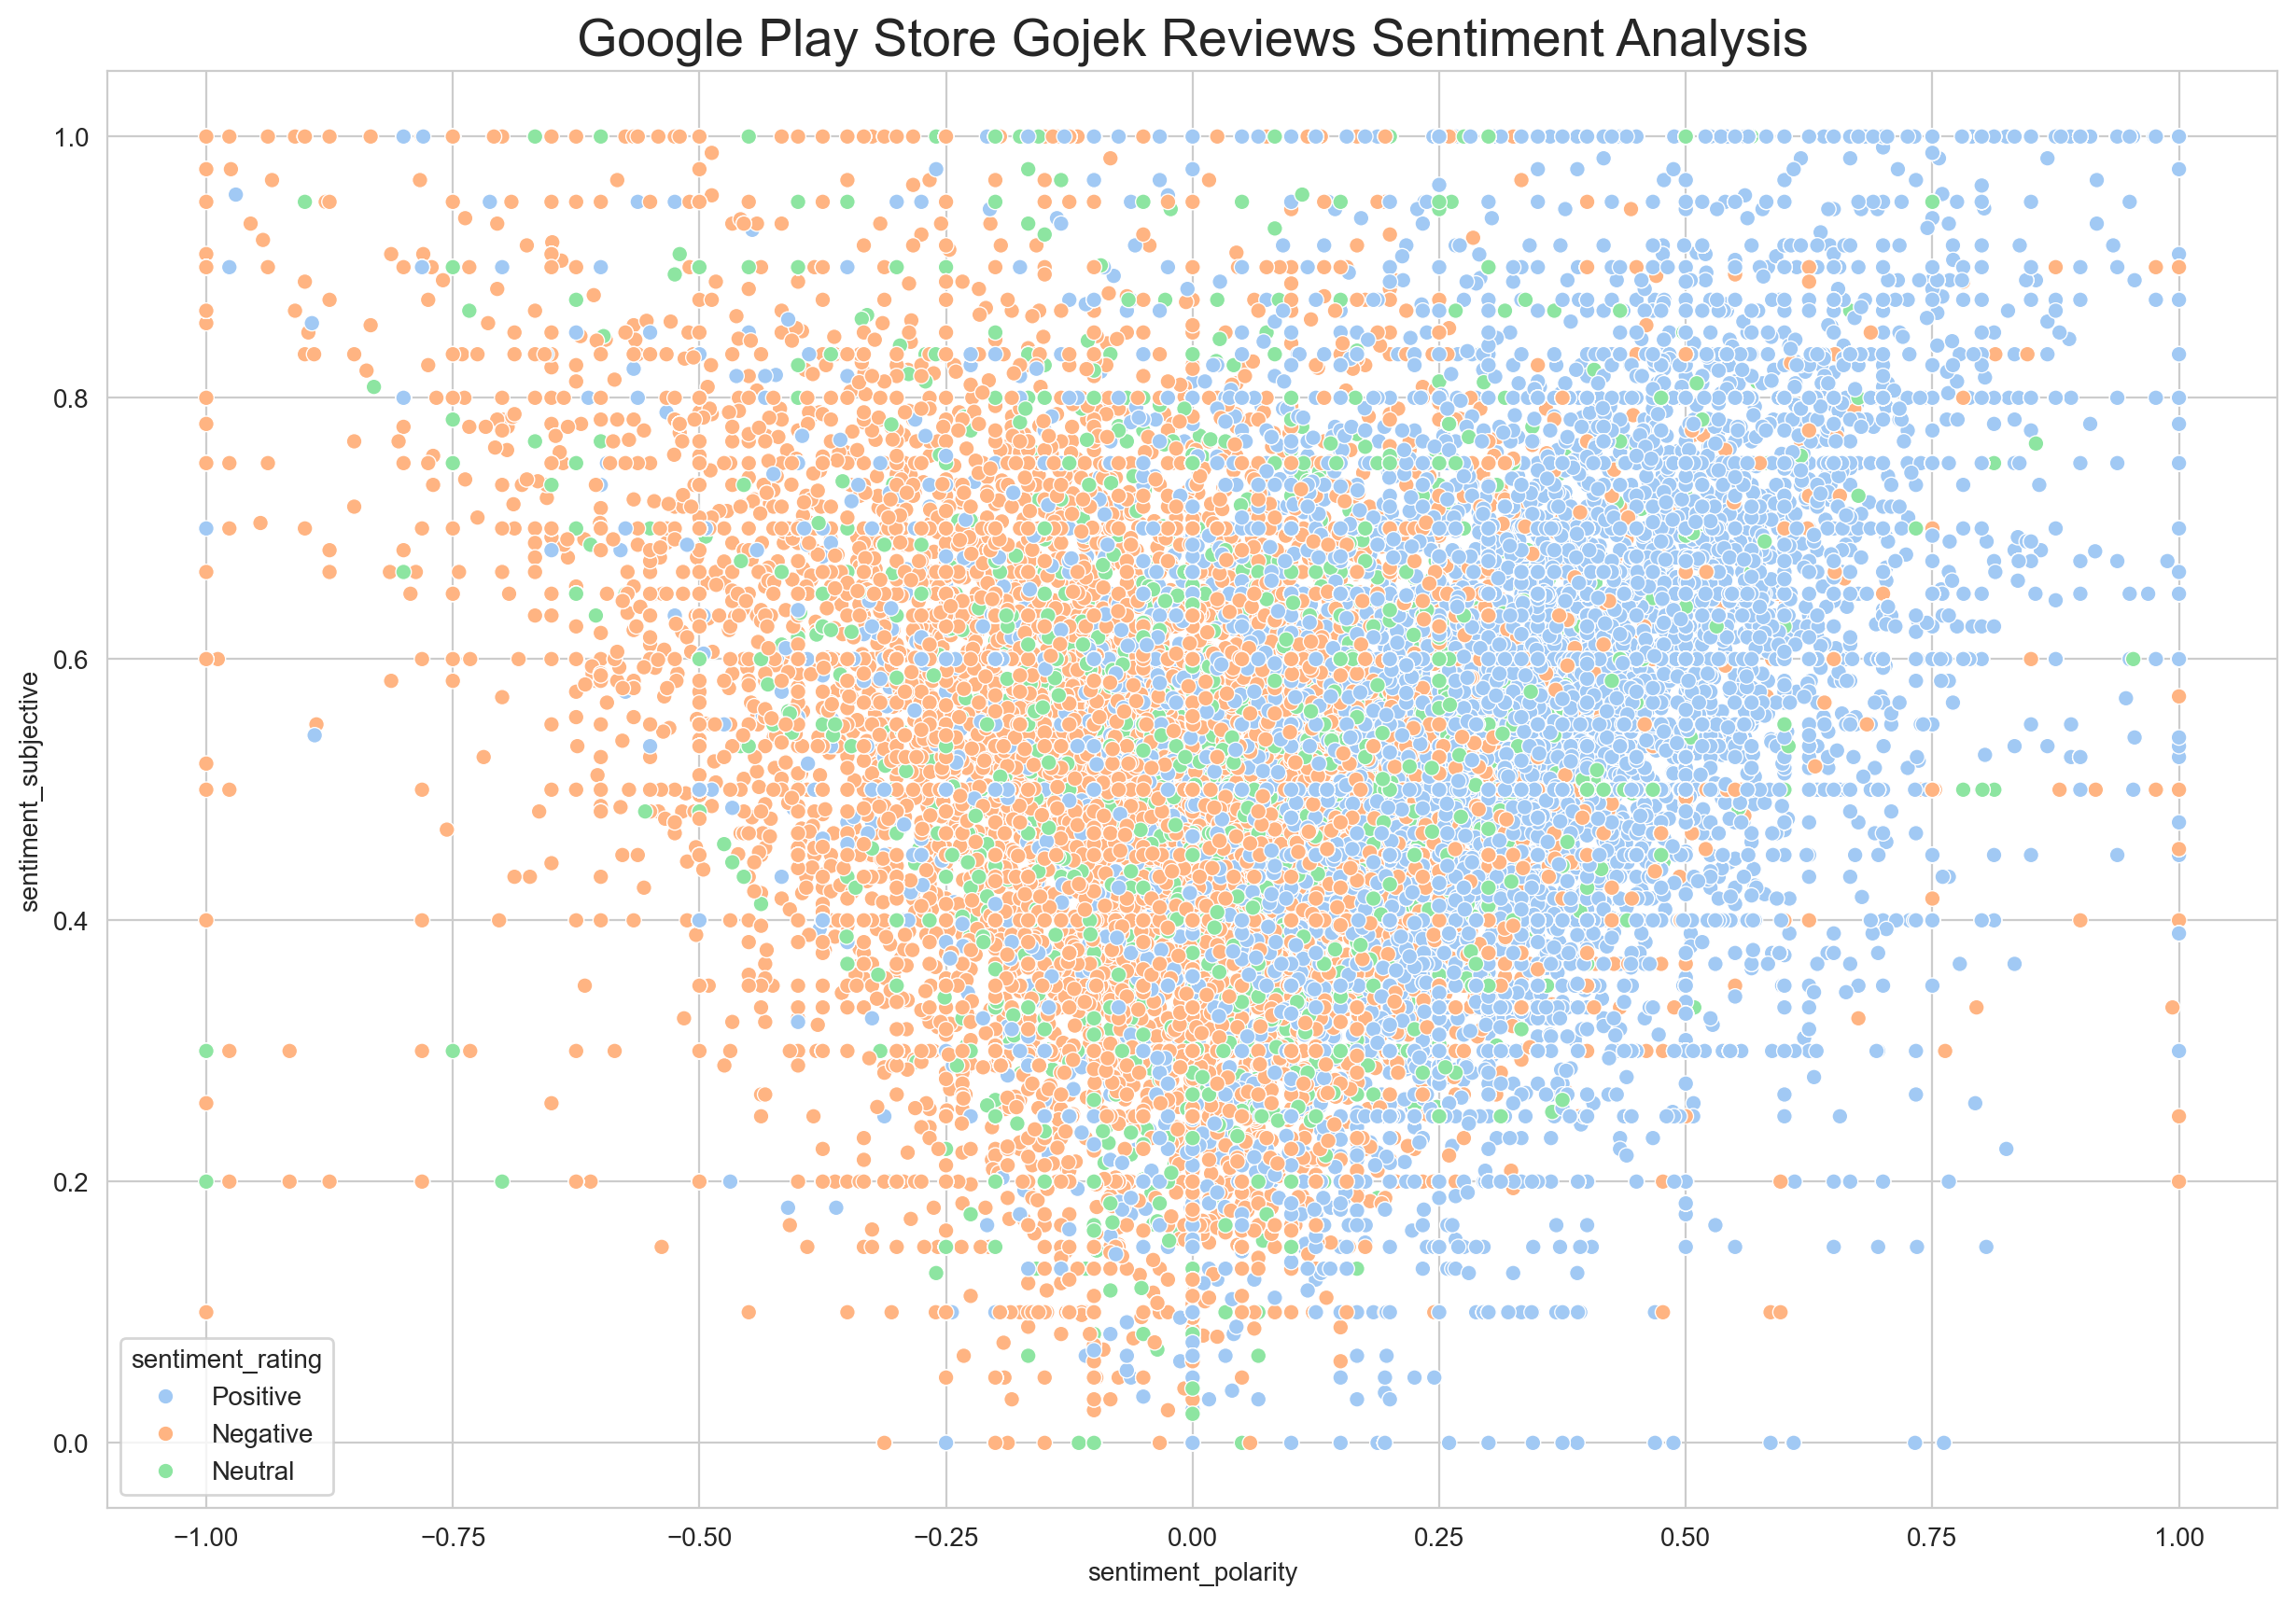

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis before preprocessing", fontsize=20)
plt.show()

In [ ]:
!pip install emoji

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

<h3>a. Lowercasing</h3>

In [13]:
# Lower casing
# Change the reviews type to string
df_gjkrev['content'] = df_gjkrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

I just looked at the menu and try putting some dish in the order basket, to see how much it cost. I was going to order for tomorrow. Suddenly maybe I accidentally touch the ORDER button without knowing, and the app send the order. I immediately hit the cancel order, in less than one second. But the order can not be cancelled. I hit the NEED HELP button. The CS said the order can not be cancelled. Edit: NOW THE APP GIVES A WARNING, PLS CHECK YOUR ORDER AGAIN (SO YOU CAN CANCEL). THAT'S GOOD.
kendaraan nyaman dan tepat waktu
Titik nya salah terus, gak gampang gunainnya sekarang


In [14]:
#Lowercase all reviews to see the difference
df_gjkrev['content']= df_gjkrev['content'].apply(lambda x: x.lower())
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

i just looked at the menu and try putting some dish in the order basket, to see how much it cost. i was going to order for tomorrow. suddenly maybe i accidentally touch the order button without knowing, and the app send the order. i immediately hit the cancel order, in less than one second. but the order can not be cancelled. i hit the need help button. the cs said the order can not be cancelled. edit: now the app gives a warning, pls check your order again (so you can cancel). that's good.
kendaraan nyaman dan tepat waktu
titik nya salah terus, gak gampang gunainnya sekarang


In [15]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

content  score  \
0                                  sangat membantu sekali      5   
1                        kendaraan nyaman dan tepat waktu      5   
2                         very reliable for my daily life      5   
3       driver sering minta batal tapi harus kita yang...      2   
4       kenapa driver bisa liat rating tapi kita sendi...      3   
...                                                   ...    ...   
226074                                      love this app      5   
226075                              akhirnya keluar juga!      5   
226076                                            finally      5   
226077                                            helpful      4   
226078                                     usefull banget      5   

        sentiment_polarity  sentiment_subjective  
0                      0.0                  0.00  
1                      0.0                  0.00  
2                      0.1                  0.15  
3                      0.0                  0.00  
4                      0.0                  0.00  
...                    ...                   ...  
226074                 0.5                  0.60  
226075                 0.0                  0.00  
226076                 0.0                  1.00  
226077                 0.0                  0.00  
226078                 0.0                  0.00  

[226079 rows x 4 columns]

<h3>b. Stopwords Removal</h3>

In [ ]:
!pip install Sastrawi

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

df_gjkrev['wordCount'] = [len(review.split()) for review in df_gjkrev['content']]
df_gjkrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_gjkrev['content']]
df_gjkrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_gjkrev['content']]

In [20]:
# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_gjkrev[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

In [21]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

content  score  \
0                                  sangat membantu sekali      5   
1                        kendaraan nyaman dan tepat waktu      5   
2                         very reliable for my daily life      5   
3       driver sering minta batal tapi harus kita yang...      2   
4       kenapa driver bisa liat rating tapi kita sendi...      3   
...                                                   ...    ...   
226074                                      love this app      5   
226075                              akhirnya keluar juga!      5   
226076                                            finally      5   
226077                                            helpful      4   
226078                                     usefull banget      5   

        sentiment_polarity  sentiment_subjective  wordCount  \
0                      0.0                  0.00          3   
1                      0.0                  0.00          5   
2                      0.1                  0.15          6   
3                      0.0                  0.00         12   
4                      0.0                  0.00         16   
...                    ...                   ...        ...   
226074                 0.5                  0.60          3   
226075                 0.0                  0.00          3   
226076                 0.0                  1.00          1   
226077                 0.0                  0.00          1   
226078                 0.0                  0.00          2   

        uppercaseCharCount  specialCharCount  
0                        0                 0  
1                        0                 0  
2                        0                 0  
3                        0                 2  
4                        0                 1  
...                    ...               ...  
226074                   0                 0  
226075                   0                 1  
226076                   0                 0  
226077                   0                 0  
226078                   0                 0  

[226079 rows x 7 columns]

In [ ]:
# Indonesian Stopword Removal using Sastrawi
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

sastrawi_stopwords = factory.get_stop_words()
print(f"There's total {len(sastrawi_stopwords)} Indonesian stopwords removed.")

There's total 126 Indonesian stopwords removed.


In [36]:
# English Stopword Removal using NLTK
# Get English stopwords
import nltk
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

# To get the number of English stopwords, use the len() function:
print(f"There's total {len(english_stopwords)} English stopwords removed.")


There's total 198 English stopwords removed.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# Apply stopword removal to the 'content' column
df_gjkrev['content'] = df_gjkrev['content'].apply(lambda x: stopword_remover.remove(x))

<h3>c. Cleaning Text</h3>

In [39]:
import re
import string

def cleaning_text(text):
  # Menambah spasi setelah koma pada koma yang tidak diberi spasi
  text = re.sub(r",(?!\s)", ", ", text)
  # Menghapus tab, new line, back slice, dll
  text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
  # Menghapus karakter non ASCII (emoticon, chinese word, dll),
  text = text.encode('ascii', 'replace').decode('ascii')
  # Menghapus URL
  text = re.sub(r"(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?", "", text)
  # Menghapus angka
  text = re.sub(r"\d+", "", text)
  # Menghapus tanda baca
  text = text.translate(str.maketrans("", "", string.punctuation))
  # Menghapus whitespace di depan/belakang teks dan double++ spasi
  text = text.strip()
  text = re.sub('\s+', ' ', text)
  # Menghapus single character
  return re.sub(r"\b[a-zA-Z]\b", "", text)

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
C:\Users\VICTUS\AppData\Local\Temp\ipykernel_17444\975323572.py:19: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [40]:
df_gjkrev['clean'] = df_gjkrev['content'].apply(cleaning_text)

<h2>#3 Hasil Review</h2>

<h3>a. Frequency Words</h3>

Word  Frequency
0      the      35181
1     good      29555
2       to      28082
3   driver      26727
4    gojek      24799
..     ...        ...
95     was       2978
96   harga       2919
97      or       2904
98    from       2903
99     get       2887

[100 rows x 2 columns]

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_17444\856327870.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


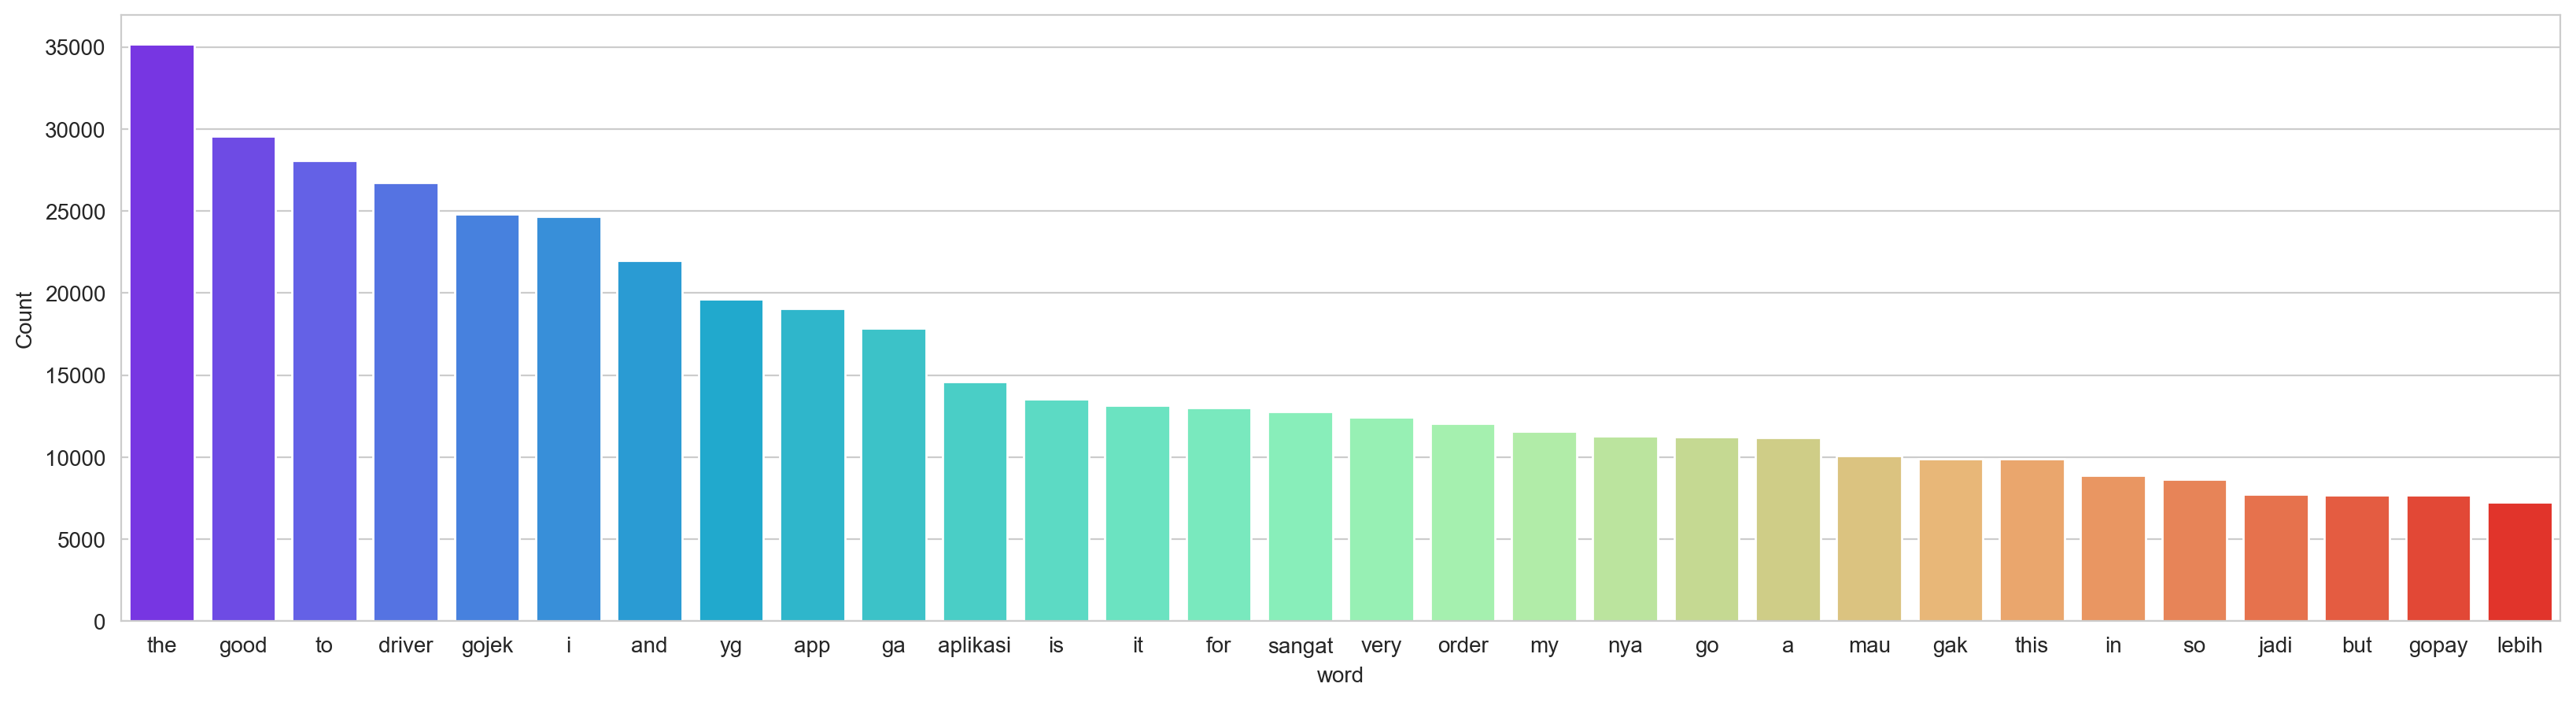

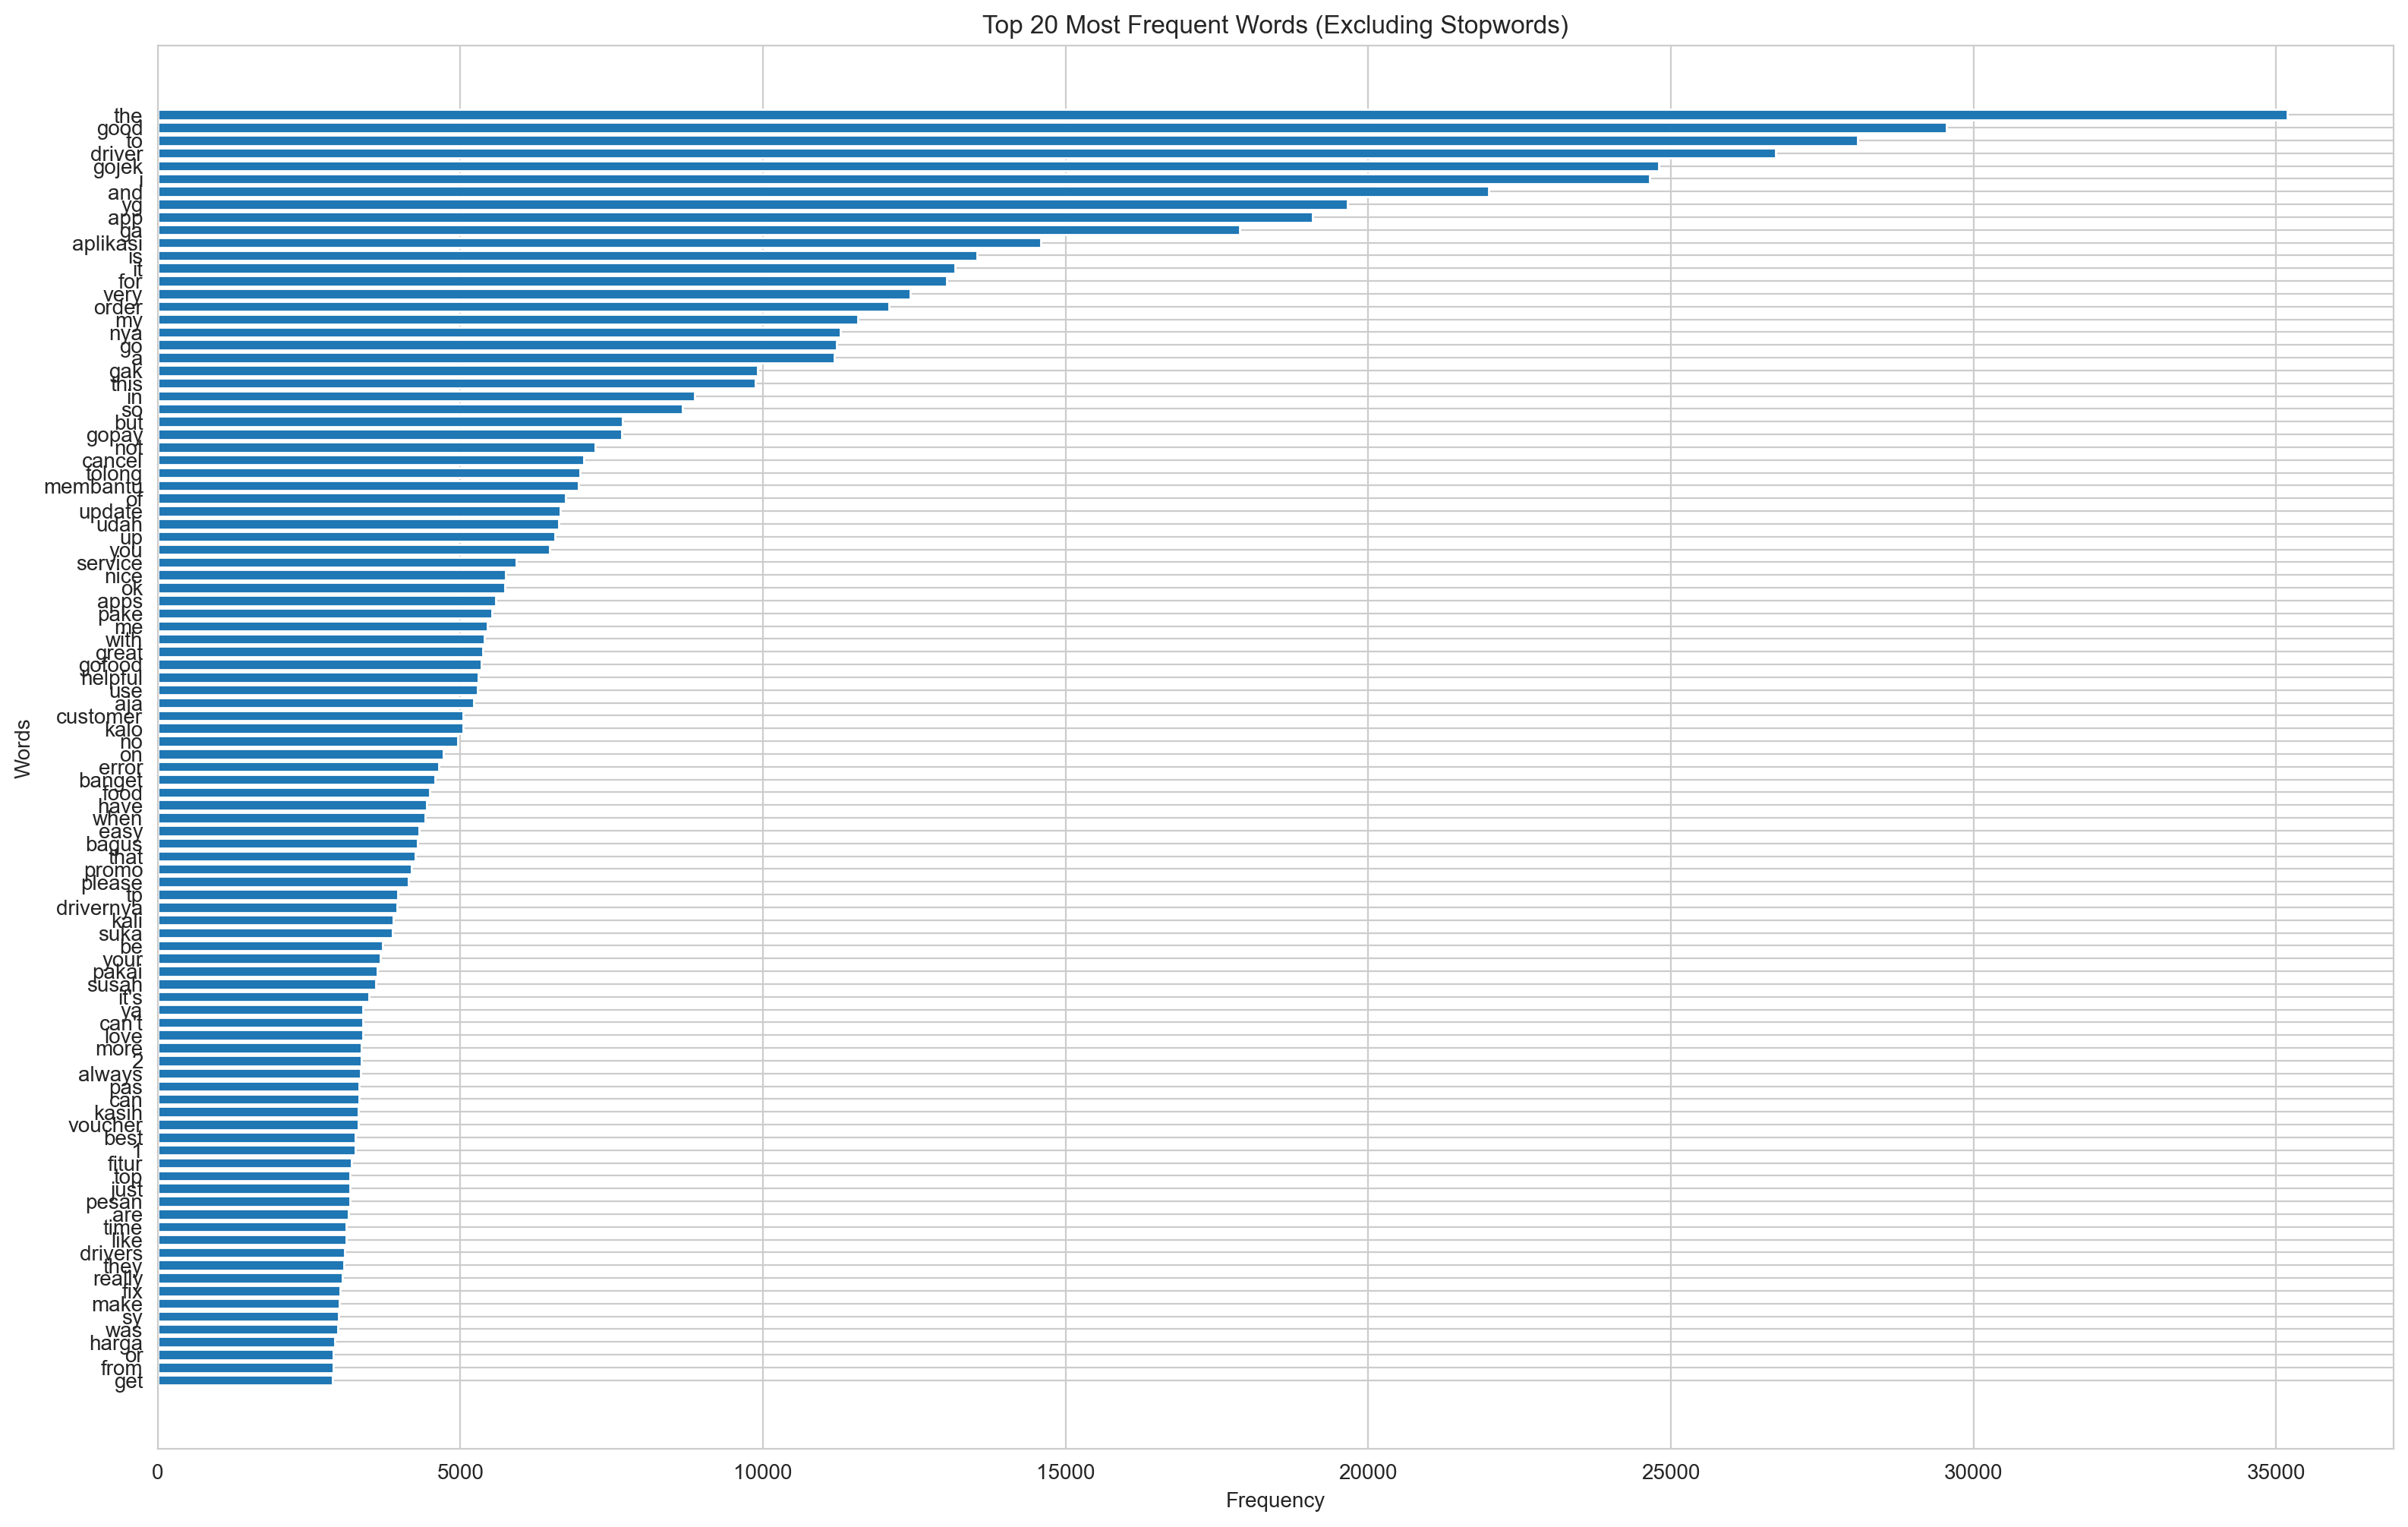

In [41]:
# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

# Plot the frequent words
freq_words(df_gjkrev['content'])
plt.figure(figsize=(19, 12))
plt.barh(word_freq_df['Word'][::-1], word_freq_df['Frequency'][::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.show()

<b>Sentiment Analysis after Preprocessing</b>

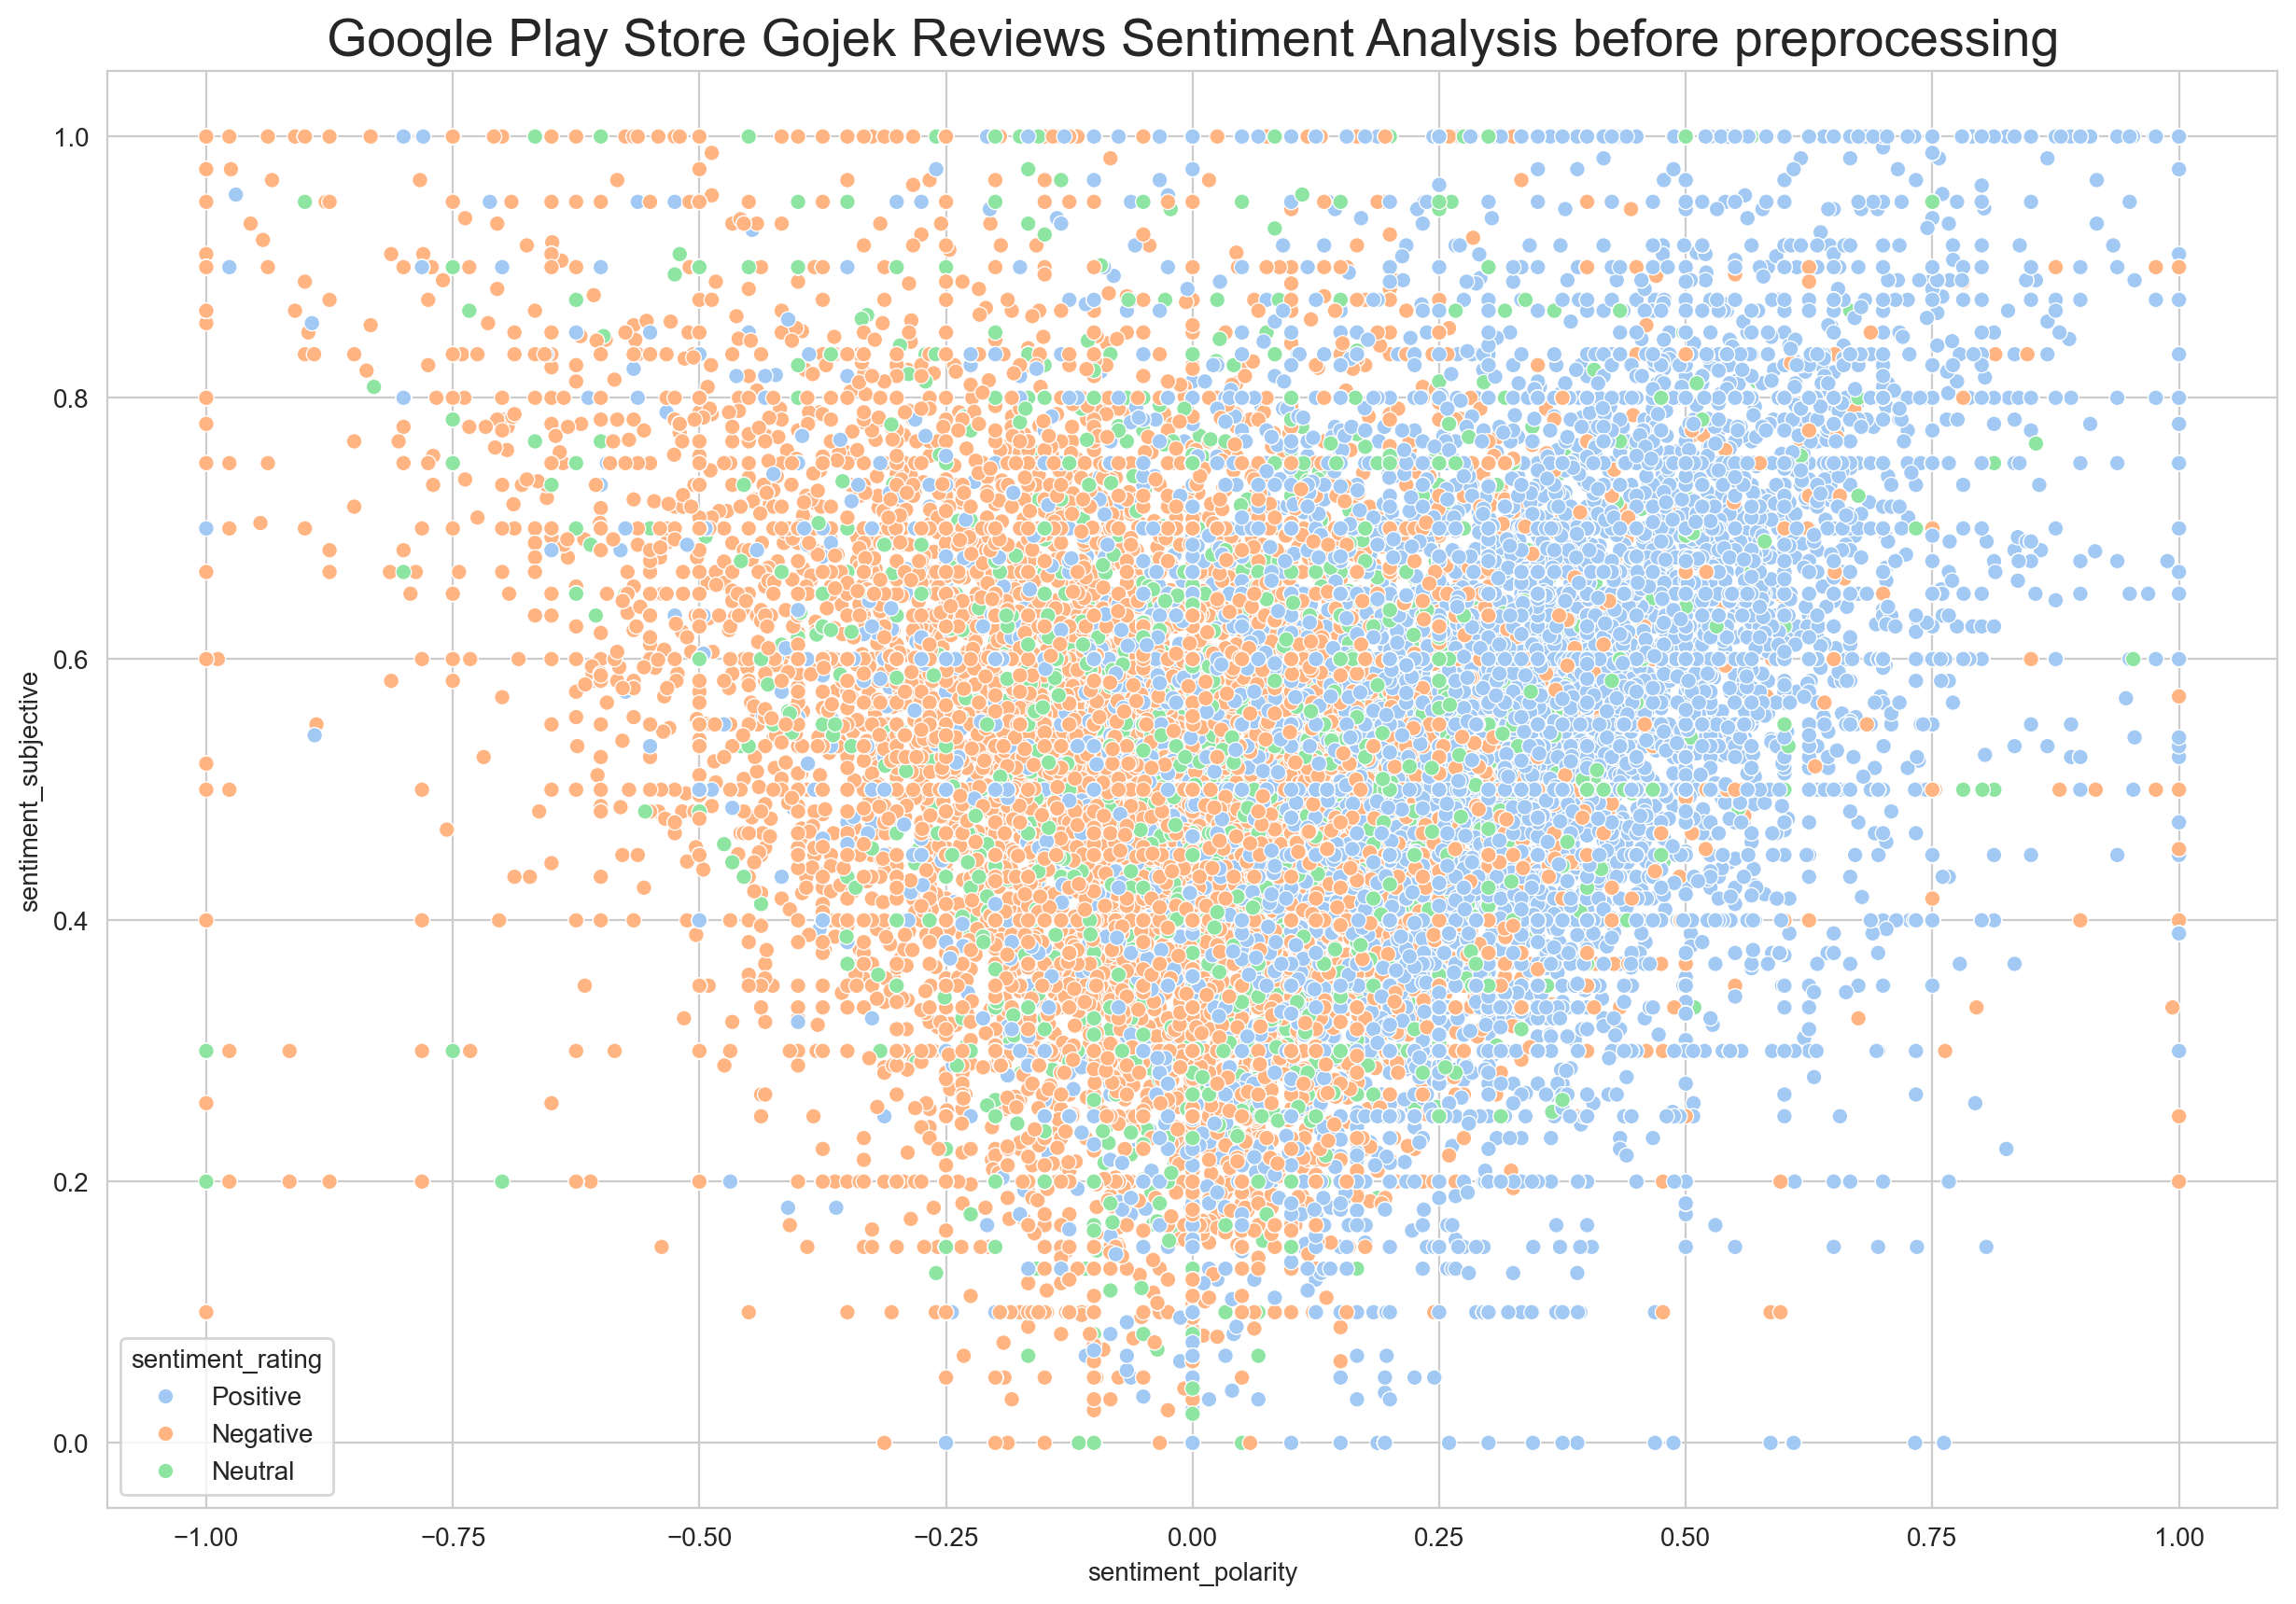

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis After preprocessing", fontsize=20)
plt.show()